In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Layer, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

train_dir = '/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment'
print(os.listdir(train_dir))

['Nematode', 'Bacteria', 'Healthy', 'Phytopthora', 'Fungi', 'Pest', 'Virus']


In [7]:

# Define dataset parameters
batch_size = 32
img_height = 224
img_width = 224

# Load training and validation datasets
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check the class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 3076 files belonging to 7 classes.
Using 2461 files for training.
Found 3076 files belonging to 7 classes.
Using 615 files for validation.
Class names: ['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


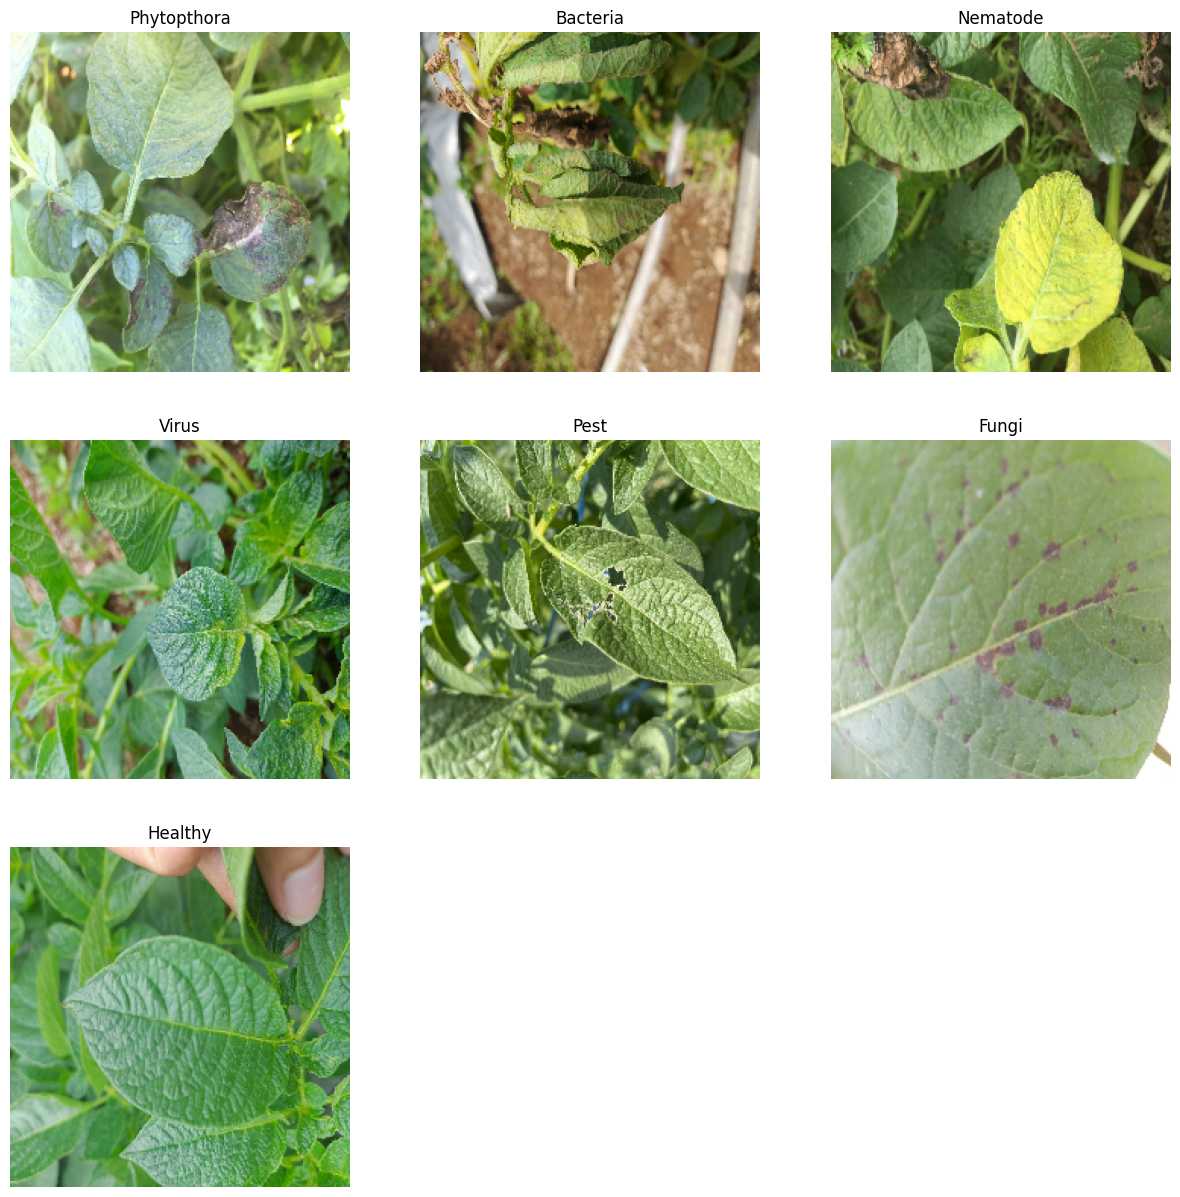

In [8]:
# Function to plot one image from each class
def plot_one_image_per_class(dataset, class_names):
    plt.figure(figsize=(15, 15))
    num_classes = len(class_names)
    images_shown = {class_name: False for class_name in class_names}
    images_plotted = 0

    for images, labels in dataset.unbatch():
        label = class_names[labels.numpy()]
        if not images_shown[label]:
            ax = plt.subplot(3, 3, images_plotted + 1)
            plt.imshow(images.numpy().astype("uint8"))
            plt.title(label)
            plt.axis("off")
            images_shown[label] = True
            images_plotted += 1
        
        if images_plotted == num_classes:
            break

    plt.show()

# Call the function to plot one image from each class
plot_one_image_per_class(train_ds, class_names)

In [9]:
# Define the augmentation pipeline
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.3),
    RandomBrightness(0.1)
])

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

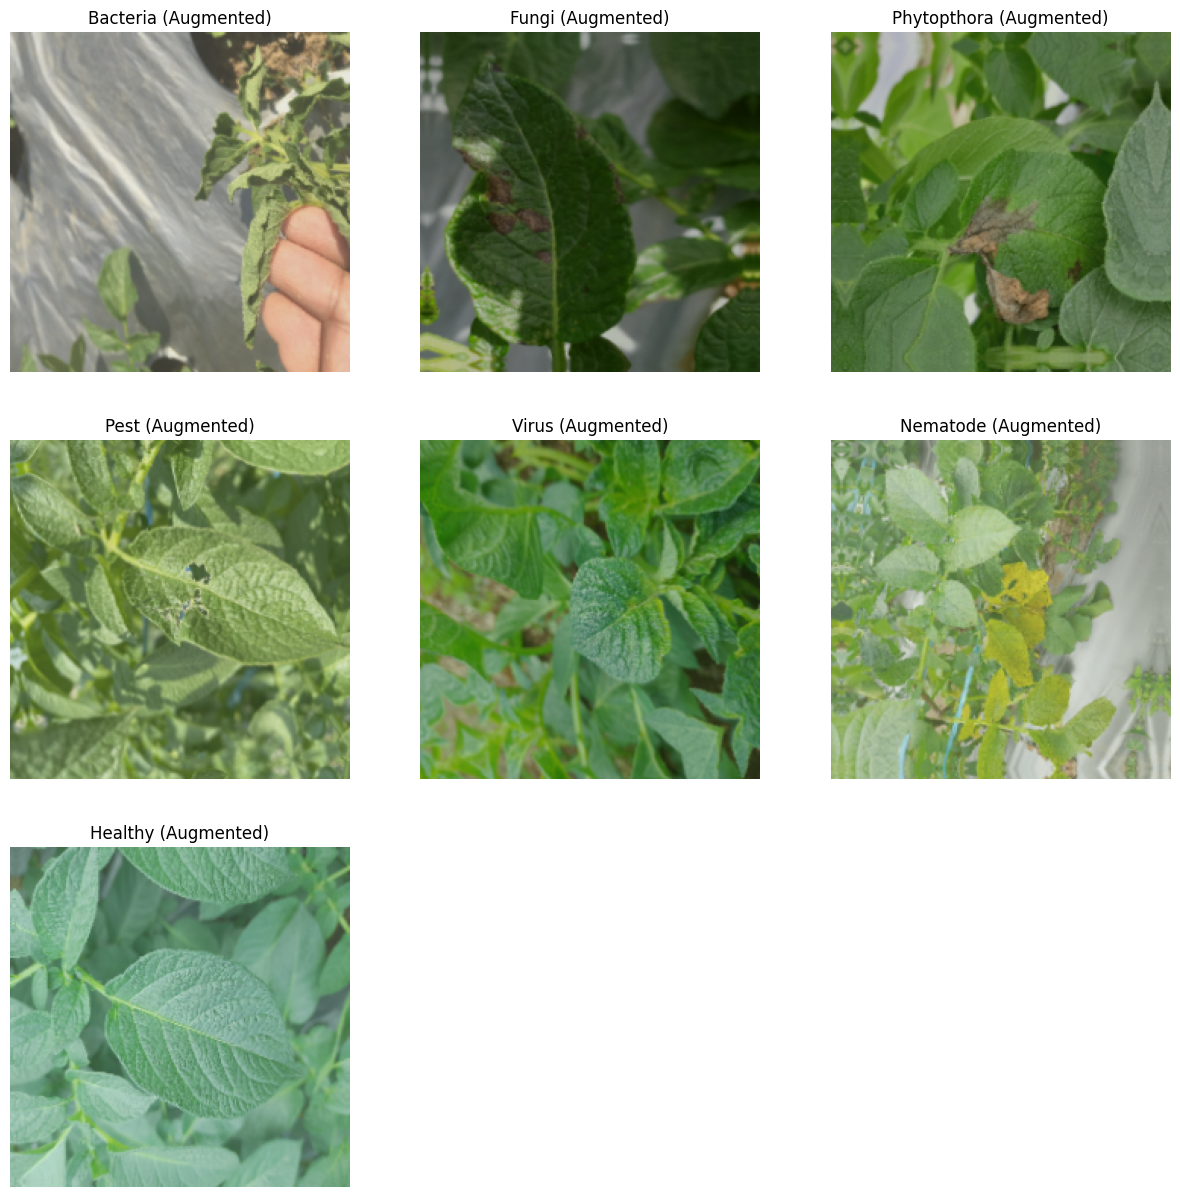

In [10]:
# Function to plot one augmented image from each class
def plot_one_augmented_image_per_class(dataset, class_names):
    plt.figure(figsize=(15, 15))
    num_classes = len(class_names)
    images_shown = {class_name: False for class_name in class_names}
    images_plotted = 0

    for images, labels in dataset.unbatch():
        label = class_names[labels.numpy()]
        if not images_shown[label]:
            ax = plt.subplot(3, 3, images_plotted + 1)
            plt.imshow(images.numpy().astype("uint8"))
            plt.title(label + " (Augmented)")
            plt.axis("off")
            images_shown[label] = True
            images_plotted += 1
        
        if images_plotted == num_classes:
            break

    plt.show()

# Call the function to plot one augmented image from each class
plot_one_augmented_image_per_class(augmented_train_ds, class_names)

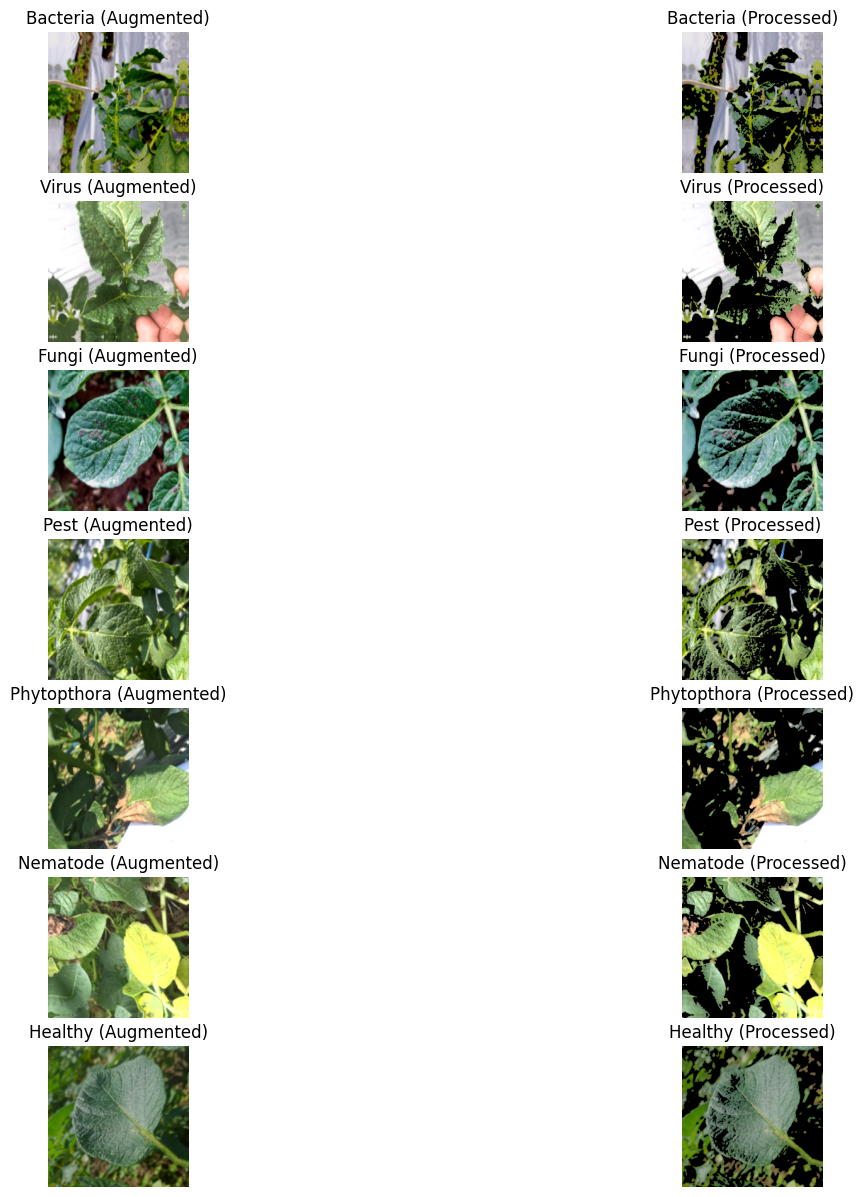

In [13]:
# Define the image processing function
def process_image(image):
    # Convert to grayscale
    gray_image = tf.image.rgb_to_grayscale(image)
    
    # Enhance contrast
    enhanced_contrast_image = tf.image.adjust_contrast(gray_image, 5)
    
    # Apply thresholding to create a binary mask
    threshold_image = tf.where(enhanced_contrast_image > 0.5, 1.0, 0.0)
    
    # Create a mask to highlight only the affected areas
    mask = tf.cast(threshold_image, tf.float32)
    highlighted_image = image * mask
    
    return highlighted_image

# Function to plot the original and processed images
def plot_processed_images(dataset, class_names):
    plt.figure(figsize=(15, 15))
    num_classes = len(class_names)
    images_shown = {class_name: False for class_name in class_names}
    images_plotted = 0

    for images, labels in dataset.unbatch():
        label = class_names[labels.numpy()]
        if not images_shown[label]:
            original_image = images.numpy().astype("uint8")
            processed_image = process_image(images)
            
            ax = plt.subplot(num_classes, 2, images_plotted * 2 + 1)
            plt.imshow(original_image)
            plt.title(label + " (Augmented)")
            plt.axis("off")
            
            ax = plt.subplot(num_classes, 2, images_plotted * 2 + 2)
            plt.imshow(processed_image.numpy().astype("uint8"))
            plt.title(label + " (Processed)")
            plt.axis("off")

            images_shown[label] = True
            images_plotted += 1
        
        if images_plotted == num_classes:
            break

    plt.show()

# Call the function to plot processed images
plot_processed_images(augmented_train_ds, class_names)

In [14]:

# Apply image processing to the training dataset
processed_train_ds = augmented_train_ds.map(
    lambda x, y: (process_image(x), y))

# Apply image processing to the validation dataset
processed_val_ds = val_ds.map(
    lambda x, y: (process_image(x), y))

# Define the CNN model
def create_cnn_model():
    model = Sequential([
        Input(shape=(img_height, img_width, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(1024, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the CNN model
cnn_model = create_cnn_model()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the CNN model with early stopping
history = cnn_model.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = cnn_model.evaluate(processed_val_ds)
print(f"Validation accuracy: {accuracy:.2f}")

Epoch 1/200
 2/77 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.1484 - loss: 2.7950  

I0000 00:00:1716907712.933025     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716907712.953488     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.1855 - loss: 2.0296

W0000 00:00:1716907766.835769     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716907769.431841     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 88s 790ms/step - accuracy: 0.1858 - loss: 2.0276 - val_accuracy: 0.1837 - val_loss: 1.8216
Epoch 2/200


W0000 00:00:1716907772.959383     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 402ms/step - accuracy: 0.2278 - loss: 1.8061 - val_accuracy: 0.1837 - val_loss: 1.8237
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 409ms/step - accuracy: 0.2297 - loss: 1.7884 - val_accuracy: 0.2309 - val_loss: 1.8140
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.2530 - loss: 1.7843 - val_accuracy: 0.2195 - val_loss: 1.7984
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - accuracy: 0.2950 - loss: 1.7304 - val_accuracy: 0.2683 - val_loss: 1.7201
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step - accuracy: 0.2906 - loss: 1.6836 - val_accuracy: 0.2146 - val_loss: 1.8615
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.3230 - loss: 1.6288 - val_accuracy: 0.1951 - val_loss: 1.8598
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 400ms/step - accuracy: 0.3043 - loss: 1.6237 - val_accuracy: 0.2780 - val_loss: 1.6938
Epoch 9/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 396ms/step - accuracy: 0.3303 - loss: 1.6024 - val_accuracy

In [38]:


# Make predictions on the validation set
val_images = []
val_labels = []
for images, labels in processed_val_ds.unbatch():
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Predict the classes
predictions = cnn_model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)


# Compute precision, recall, and F1 score for each class
precision = precision_score(val_labels, predicted_classes, average=None)
recall = recall_score(val_labels, predicted_classes, average=None)
f1 = f1_score(val_labels, predicted_classes, average=None)

# Display the results
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1 Score: {f1[i]:.2f}")
    print()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class: Bacteria
  Precision: 0.90
  Recall: 0.54
  F1 Score: 0.68

Class: Fungi
  Precision: 0.46
  Recall: 0.52
  F1 Score: 0.49

Class: Healthy
  Precision: 0.30
  Recall: 0.27
  F1 Score: 0.29

Class: Nematode
  Precision: 0.81
  Recall: 0.72
  F1 Score: 0.76

Class: Pest
  Precision: 0.41
  Recall: 0.56
  F1 Score: 0.47

Class: Phytopthora
  Precision: 0.62
  Recall: 0.65
  F1 Score: 0.63

Class: Virus
  Precision: 0.59
  Recall: 0.53
  F1 Score: 0.56



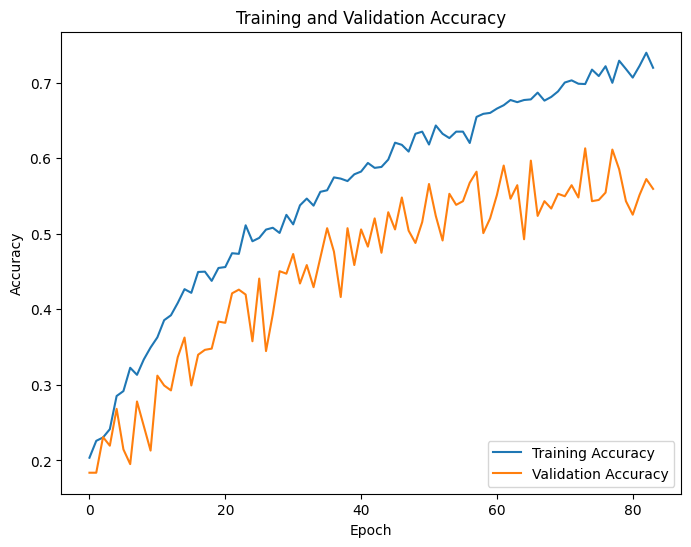

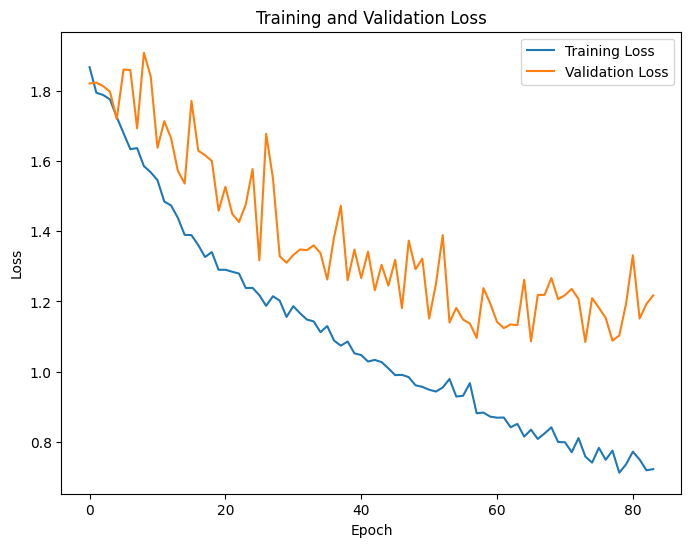

In [16]:
# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [39]:

# Define the ResNet50 model
def create_resnet50_model():
    base_model = ResNet50(input_shape=(img_height, img_width, 3),
                          include_top=False,
                          weights='imagenet')
    base_model.trainable = False
    
    model = Sequential([
        Input(shape=(img_height, img_width, 3)),
        Rescaling(1./255),
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the ResNet50 model
resnet50_model = create_resnet50_model()

# Train the ResNet50 model with early stopping
history_resnet50 = resnet50_model.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

# Evaluate the ResNet50 model
loss, accuracy = resnet50_model.evaluate(processed_val_ds)
print(f"Validation accuracy: {accuracy:.2f}")

Epoch 1/200
 2/77 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.1562 - loss: 2.5790 

W0000 00:00:1716916012.346930     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.2414 - loss: 2.0936

W0000 00:00:1716916042.138737     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716916047.200739     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716916050.607284     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 51s 506ms/step - accuracy: 0.2416 - loss: 2.0916 - val_accuracy: 0.1772 - val_loss: 1.8024
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 402ms/step - accuracy: 0.2832 - loss: 1.7515 - val_accuracy: 0.2780 - val_loss: 1.7252
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 399ms/step - accuracy: 0.2864 - loss: 1.7127 - val_accuracy: 0.2764 - val_loss: 1.7300
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - accuracy: 0.2906 - loss: 1.7119 - val_accuracy: 0.2862 - val_loss: 1.7074
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 404ms/step - accuracy: 0.2813 - loss: 1.7059 - val_accuracy: 0.3220 - val_loss: 1.6914
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - accuracy: 0.2975 - loss: 1.7011 - val_accuracy: 0.3431 - val_loss: 1.6778
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - accuracy: 0.2871 - loss: 1.6957 - val_accuracy: 0.3285 - val_loss: 1.6727
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 398ms/step - accuracy: 0.3061 - loss: 1.6797 - val_accuracy

In [41]:


# Predict the classes
predictions = resnet50_model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)


# Compute precision, recall, and F1 score for each class
precision = precision_score(val_labels, predicted_classes, average=None)
recall = recall_score(val_labels, predicted_classes, average=None)
f1 = f1_score(val_labels, predicted_classes, average=None)

# Display the results
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1 Score: {f1[i]:.2f}")
    print()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
Class: Bacteria
  Precision: 0.54
  Recall: 0.75
  F1 Score: 0.63

Class: Fungi
  Precision: 0.32
  Recall: 0.60
  F1 Score: 0.42

Class: Healthy
  Precision: 0.00
  Recall: 0.00
  F1 Score: 0.00

Class: Nematode
  Precision: 0.00
  Recall: 0.00
  F1 Score: 0.00

Class: Pest
  Precision: 0.25
  Recall: 0.18
  F1 Score: 0.21

Class: Phytopthora
  Precision: 0.42
  Recall: 0.24
  F1 Score: 0.31

Class: Virus
  Precision: 0.48
  Recall: 0.30
  F1 Score: 0.37



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


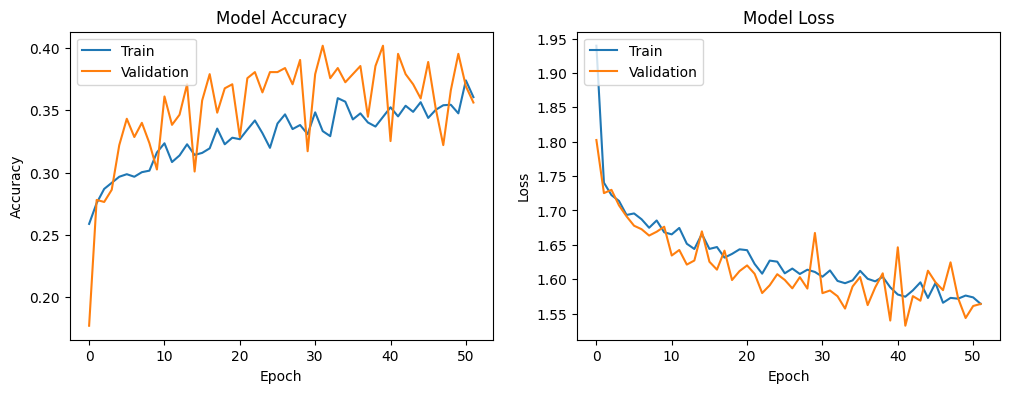

In [43]:

# Function to plot the learning curves
def plot_learning_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Call the function to plot the learning curves
plot_learning_curves(history_resnet50)


In [44]:

# Define the EfficientNet model
def create_efficientnet_model():
    base_model = EfficientNetB0(input_shape=(img_height, img_width, 3),
                                include_top=False,
                                weights='imagenet')
    base_model.trainable = False
    
    model = Sequential([
        Input(shape=(img_height, img_width, 3)),
        Rescaling(1./255),
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Create the EfficientNet model
efficientnet_model = create_efficientnet_model()

# Train the EfficientNet model with early stopping
history_efficientnet = efficientnet_model.fit(
    processed_train_ds,
    validation_data=processed_val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

# Evaluate the EfficientNet model
loss, accuracy = efficientnet_model.evaluate(processed_val_ds)
print(f"Validation accuracy: {accuracy:.2f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/200
 4/77 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.2539 - loss: 1.8971

W0000 00:00:1716918634.924429     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.2347 - loss: 1.8252

W0000 00:00:1716918684.199916     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716918691.562352     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 102s 851ms/step - accuracy: 0.2347 - loss: 1.8250 - val_accuracy: 0.1837 - val_loss: 1.8527
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 387ms/step - accuracy: 0.2435 - loss: 1.8068 - val_accuracy: 0.1837 - val_loss: 1.8439
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 387ms/step - accuracy: 0.2234 - loss: 1.8045 - val_accuracy: 0.2309 - val_loss: 1.8193
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 388ms/step - accuracy: 0.2254 - loss: 1.7946 - val_accuracy: 0.2309 - val_loss: 1.8257
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 387ms/step - accuracy: 0.2333 - loss: 1.8029 - val_accuracy: 0.2309 - val_loss: 1.8186
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 385ms/step - accuracy: 0.2418 - loss: 1.8061 - val_accuracy: 0.2309 - val_loss: 1.8198
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 387ms/step - accuracy: 0.2559 - loss: 1.7884 - val_accuracy: 0.2309 - val_loss: 1.8184
Epoch 8/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 386ms/step - accuracy: 0.2506 - loss: 1.7944 - val_accurac